In [1]:
from sklearn.metrics import accuracy_score

true_label = []
predicted_label = []

def is_sat(line):
    assert ("SAT" in line) or ("UNSAT" in line)
    return " SAT" in line

# read lines from ../predictions/out-sat-dpll.txt
with open('../predictions/out-sat-dpll2.txt', 'r') as f:
    for line in f:
        if is_sat(line):
            predicted_label.append(1)
        else:
            predicted_label.append(0)

# read lines from ../data/SAT_DPLL/SAT_DATASET_DPLL_Balanced_test.txt
with open('../data/SAT_DPLL/SAT_DATASET_DPLL_Balanced_test.txt', 'r') as f:
    for line in f:
        if is_sat(line):
            true_label.append(1)
        else:
            true_label.append(0)

print(predicted_label, len(predicted_label))
# print the accuracy
assert(len(predicted_label) == len(true_label))
print("Accuracy: ", accuracy_score(true_label, predicted_label))

[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] 100
Accuracy:  0.61


In [42]:
correct = [1 if predicted_label[i] == true_label[i] else 0 for i in range(len(predicted_label))]


incorrect_sat = [1 if correct[i] == 0 and true_label[i] == 1 else 0 for i in range(len(correct))]
incorrect_unsat = [1 if correct[i] == 0 and true_label[i] == 0 else 0 for i in range(len(correct))]

# very biased to predict UNSAT when SAT on 36/39 incorrect samples
print("Incorrect SAT: ", sum(incorrect_sat))
print("Incorrect UNSAT: ", sum(incorrect_unsat))
print("Total true sat", sum(true_label))
print("Total predicted sat", sum(predicted_label))

Incorrect SAT:  36
Incorrect UNSAT:  3
Total true sat 50
Total predicted sat 17


In [36]:
from AssignTrace import AssignTraceCDCL

wrong_active = [0 for _i in range(len(correct))]
missing_props = [0 for _i in range(len(correct))]
invalid_prop = [0 for _i in range(len(correct))]
already_assigned_prop = [0 for _i in range(len(correct))]
total_active = [0 for _i in range(len(correct))]
total_prop = [0 for _i in range(len(correct))]
not_conflicting = [0 for _i in range(len(correct))]
sat_infer = [0 for _i in range(len(correct))] # when entire trace is right, but SAT/UNSAT is wrong

def string_to_clause(line):
    clauses = line.split(" 0 ")
    clauses = [clause.strip().split(" ") for clause in clauses if clause != ""]
    ret = []
    for clause in clauses:
        for j, prop in enumerate(clause):
            if prop == "-":
                clause[j+1] =  "-" + clause[j+1]
        ret.append([int(prop) for prop in clause if prop != "-"])
    return ret
 
def string_to_clause2(line):
    clauses = line.split(" ")
    for j, prop in enumerate(clauses):
        if prop == "-":
            clauses[j+1] =  "-" + clauses[j+1]
    clauses = [token for token in clauses if token != "-"]
    return clauses

def can_prop(tracer, i):
    for clause in tracer.clauses:
        if i in clause and len(clause) == 1:
            assert not tracer.is_assigned(i)
            return True
    return False

def can_parse_to_int(s):
    try:
        int(s)
        return True
    except ValueError:
        print("Cannot parse to int: ", s)
        return False
    
with open('../predictions/out-sat-dpll2.txt', 'r') as f:
    for i, line in enumerate(f):
        if correct[i] == 0:
            clauses = string_to_clause(line[:line.index("[SEP]")])
            tracer = AssignTraceCDCL(clauses, 20)
            trace = string_to_clause2(line[line.index("[SEP]") + 5:])
            
            set_active = False
            var_stk = [[] for i in range(tracer.num_vars)] # mx num of vars
            lvl = 0
            for j in range(len(trace)):
                if trace[j] == "(":
                    set_active = True
                elif trace[j] == ")":
                    # Missing any props?
                    for x in range(1, tracer.num_vars + 1):
                        if not tracer.is_assigned(x) and can_prop(tracer, abs(x)):
                            missing_props[i] += 1
                    
                    # Is assignment actually conflicting?
                    if not tracer.res == "UNSAT":
                        not_conflicting[i] += 1

                    # Backtrack
                    for x in var_stk[lvl]:
                        tracer.unassign(x)
                    lvl -= 1
                    pass
                elif trace[j] == "SAT" or trace[j] == "UNSAT":
                    pass
                else: # is a number
                    if can_parse_to_int(trace[j]):
                        x = int(trace[j])
                    else:
                        continue
                    print("A", x, var_stk)
                    
                    if set_active:
                        total_active[i] += 1
                        if tracer.is_assigned(abs(x)):
                            wrong_active[i] += 1
                            continue
                        tracer.active_assign(abs(x))
                        lvl += 1
                        var_stk[lvl].append(abs(x))
                    else:
                        if tracer.is_assigned(x):
                            already_assigned_prop[i] += 1
                            continue
                        total_prop[i] += 1
                        # testing if is one clause where x is the only unassigned prop
                        ok = False
                        for clause in tracer.clauses:
                            if x in clause and len(clause) == 1:
                                ok = True
                                break
                        if not ok:
                            print(x, " is invalid prop", tracer.clauses)
                            invalid_prop[i] += 1
                        tracer.passive_assign(abs(x), [])
                        var_stk[lvl].append(abs(x))

                    set_active = False
            # break

invalid_prop

Cannot parse to int:  
A -9 [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
A 11 [[], [9], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
A 5 [[], [9], [11], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
5  is invalid prop [[1, 4, 7], [], [-5, -10], [2, -1, -10], [-7, 10, 4], [], [-8, 8, 3], [2, 4, 5], [8, 1, 4], [-8, 1, -7], [-8, 4, 5], [], [4, -1], [8, -6], [-7, -4, 7], [], [10, -1], [8, -1], [4, -1], [], [], [], [-3, -2, 7], [1, -6], [-4, 7], [], [2, -1], [-5, -1, 7], [10, 3, -10], [10, -5, 7], [], [], [-7, 2, 7], [2, -3, -10], [], [2, 5, -10], [-6, 3], [1, -6, 10], [2, -10], [-8, -10], [-6, -3], [-7, 10, -6], [4, 5], [2, -6, -5], [5, -1, -10], [3, -5, 4], [-8, -2, 7], [10, -6, -5], [], [2, 6, -1]]
NEW PASSIVE [[1, 4, 7], [], [-10], [2, -1, -10], [-7, 10, 4], [], [-8, 8, 3], [], [8, 1, 4], [-8, 1, -7], [], [], [4, -1], [8, -6], [-7, -4, 7], [], [10, -1], [8, -1], [4, -1], [], [], [], [-3, -2, 7], [1, -6]

[0,
 0,
 0,
 0,
 18,
 34,
 0,
 11,
 13,
 17,
 0,
 5,
 26,
 0,
 0,
 19,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 20,
 0,
 17,
 0,
 0,
 19,
 25,
 0,
 18,
 26,
 0,
 20,
 21,
 0,
 0,
 20,
 0,
 0,
 26,
 0,
 0,
 9,
 31,
 0,
 0,
 0,
 0,
 31,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 21,
 13,
 13,
 0,
 19,
 0,
 24,
 0,
 0,
 0,
 15,
 0,
 0,
 0,
 21,
 0,
 0,
 29,
 0,
 0,
 16,
 0,
 0,
 27,
 0,
 0,
 0,
 25,
 0,
 0,
 0,
 0,
 0,
 24,
 6,
 0,
 16,
 7,
 0,
 15,
 9,
 0]

[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]
[18, 34, 11, 13, 17, 5, 26, 19, 7, 20, 17, 19, 25, 18, 26, 20, 21, 20, 26, 9, 31, 31, 21, 13, 13, 19, 24, 15, 21, 29, 16, 27, 25, 24, 6, 16, 7, 15, 9]


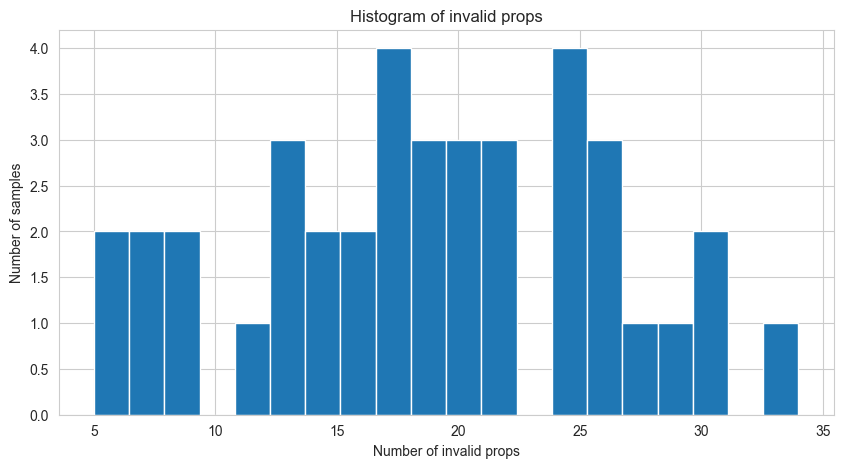

[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]
[6, 7, 7, 4, 5, 6, 3, 10, 0, 6, 3, 8, 7, 7, 4, 4, 7, 6, 3, 6, 9, 2, 5, 3, 2, 5, 3, 4, 8, 9, 3, 7, 7, 4, 4, 10, 5, 2, 5]


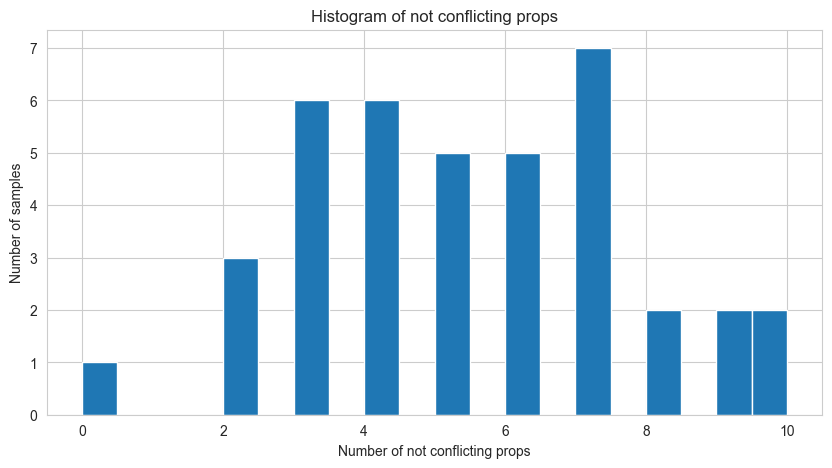

Sum of already assigned active:  0
Sum of invalid props:  733
Sum of already assigned props:  3
Sum of missing props:  259
Sum of total props:  1114
Sum of not conflicting:  206
Sum of total active sets:  309
Sum of sat_infer:  0


In [40]:
# visualize the results
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# histogram of missing props
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
print(correct)
filtered = [invalid_prop[i] for i in range(len(correct)) if correct[i] == 0]
print(filtered)
plt.hist(filtered, bins=20)
plt.xlabel("Number of invalid props")
plt.ylabel("Number of samples")
plt.title("Histogram of invalid props")
plt.show()

# histogram of not conflicting
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
print(correct)
filtered = [not_conflicting[i] for i in range(len(correct)) if correct[i] == 0]
print(filtered)
plt.hist(filtered, bins=20)
plt.xlabel("Number of not conflicting props")
plt.ylabel("Number of samples")
plt.title("Histogram of not conflicting props")
plt.show()

print("Sum of already assigned active: ", sum(wrong_active))
print("Sum of invalid props: ", sum(invalid_prop))
print("Sum of already assigned props: ", sum(already_assigned_prop))
print("Sum of missing props: ", sum(missing_props))
print("Sum of total props: ", sum(total_prop))
print("Sum of not conflicting: ", sum(not_conflicting))
print("Sum of total active sets: ", sum(total_active))
print("Sum of sat_infer: ", sum(sat_infer))